In [1]:
from MemSE import ROOT
from MemSE.nas import AccuracyDataset
import matplotlib.pyplot as plt
import torch
import ujson as json

memse_dataset = AccuracyDataset(ROOT / 'experiments/conference_2/results')

/home/sebwood/projects/def-franlp/sebwood/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = json.load(open( ROOT / 'experiments/conference_2/results/acc.dict'))
print('Dataset loaded')
power_ascending = sorted(dataset.items(), key=lambda v: v[1]['power'])
pareto_front = []
to_save = {}
for v in power_ascending:
    k = v[0]
    v = v[1]
    if not pareto_front:
        pareto_front.append((v['power'], v['top1'], k))
        continue
    if v['top1'] > pareto_front[-1][1]:
        pareto_front.append((v['power'], v['top1'], k))

Dataset loaded


In [3]:
# DATASET OPT
dataset_results = {}
for (_, _, arch) in pareto_front:
    arch = json.loads(arch)
    gmax = arch.pop('gmax')
    dataset_results[json.dumps(arch)] = [gmax]

# GA OPT
results = torch.load(ROOT / 'experiments/conference_2/results/ga_results.pth')
ga_results = {}
for _, res in results.items():
    bv, bi = res
    arch = bi[1]
    gmax = arch.pop('gmax')
    ga_results[json.dumps(arch)] = gmax
    
# GA WO GMAX OPT
results = torch.load(ROOT / 'experiments/conference_2/results/ga_results_const.pth')
ga_results_const = {}
for _, res in results.items():
    bv, bi = res
    arch = bi[1]
    gmax = arch.pop('gmax')
    ga_results_const[json.dumps(arch)] = gmax

In [4]:
res_dict = ga_results
for arch in dataset:
    arch = json.loads(arch)
    gmax = arch.pop('gmax')
    j_arch = json.dumps(arch)
    if j_arch in res_dict:
        res_dict[j_arch].append(gmax)

In [6]:
from ofa.model_zoo import ofa_net
from MemSE.nn import MemSE
ofa = ofa_net('ofa_resnet50', pretrained=True)
ofa.set_max_net()
default_gmax = MemSE(ofa.get_active_subnet()).quanter.Wmax

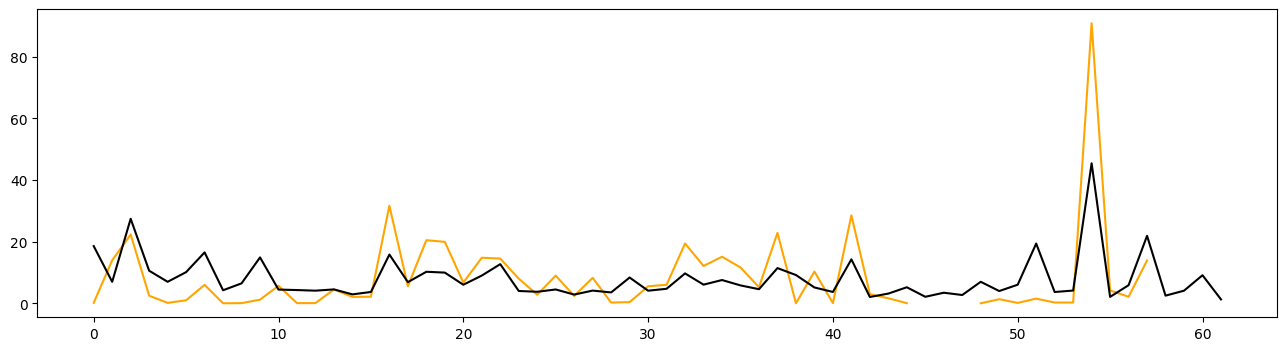

In [7]:
def plot_gmax(entry):
    # Assume entry 0 is of interest
    fig = plt.figure(figsize=(16,4))
    tensor = torch.tensor(entry)
    if len(tensor.shape) == 1:
        tensor[tensor == 0] = float("Inf")
        plt.plot(tensor, color='orange')
        plt.plot(default_gmax, color='black')
        plt.show()
        plt.close()
        return
    std, m = torch.std_mean(tensor, 0)
    tensor = (tensor - m.unsqueeze(0)) / std.unsqueeze(0)

    for point in range(tensor.shape[0] - 1, -1, -1):
        if point == 0:
            plt.plot(tensor[point], color='orange')
        else:
            plt.plot(tensor[point], color='gray')
    plt.show()
    plt.close()

for entry in res_dict.values():
    plot_gmax(entry)
    break
    